1. Gerekli kütüphaneler

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from scikeras.wrappers import KerasClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from imblearn.over_sampling import SMOTE
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

2. Veriyi okuma

In [2]:
# Verileri oku
train_df = pd.read_csv("../datasets/normal/train_mental.csv")
test_df = pd.read_csv("../datasets/normal/test_mental.csv")

# Özellik ve hedef ayır
X_train = train_df.drop("support_needed", axis=1)
y_train = train_df["support_needed"]

X_test = test_df.drop("support_needed", axis=1)
y_test = test_df["support_needed"]

# Kategorik hedefi one-hot formatına çevir (Keras için opsiyonel ama önerilir)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

print("✅ Eğitim verisi:", X_train.shape)
print("✅ Test verisi:", X_test.shape)
print("🎯 Sınıf dağılımı (y_train):\n", pd.Series(y_train).value_counts())

✅ Eğitim verisi: (1007, 23)
✅ Test verisi: (252, 23)
🎯 Sınıf dağılımı (y_train):
 support_needed
0    528
1    479
Name: count, dtype: int64


3. SMOTE ile veri dengeleme

In [3]:
print("🎯 Orijinal sınıf dağılımı:", Counter(y_train))

🎯 Orijinal sınıf dağılımı: Counter({0: 528, 1: 479})


In [4]:
# 2️⃣ Sadece sayısal olmayan sütunlar encode edilmiş varsayılıyor. Tamamını ölçekle.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
 
# 3️⃣ SMOTE ile oversampling
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("⚖️ Dengelenmiş eğitim sınıf dağılımı:", Counter(y_train_balanced))

⚖️ Dengelenmiş eğitim sınıf dağılımı: Counter({0: 528, 1: 528})


In [5]:
y_train_cat = to_categorical(y_train_balanced)
y_test_cat = to_categorical(y_test)

3. ANN modeli

In [6]:
# ANN mimarisi
model = Sequential([
    Input(shape=(X_train_balanced.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')  # 2 sınıf için softmax
])

# Derleme
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2025-05-12 11:32:11.280238: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-12 11:32:11.280270: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-05-12 11:32:11.280279: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-05-12 11:32:11.280300: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-12 11:32:11.280313: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,682 (14.38 KB)

 Trainable params: 3,682 (14.38 KB)

 Non-trainable params: 0 (0.00 B)

4. Model eğitimi

In [7]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_balanced,  
    y_train_cat,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30


2025-05-12 11:32:11.744488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5800 - loss: 0.8124 - val_accuracy: 0.7783 - val_loss: 0.4767
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7074 - loss: 0.5840 - val_accuracy: 0.7972 - val_loss: 0.4252
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7307 - loss: 0.5221 - val_accuracy: 0.8160 - val_loss: 0.4053
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7832 - loss: 0.4774 - val_accuracy: 0.8208 - val_loss: 0.3908
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7641 - loss: 0.4845 - val_accuracy: 0.8255 - val_loss: 0.3912
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7539 - loss: 0.4975 - val_accuracy: 0.8255 - val_loss: 0.3897
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7931 - loss: 0.4698 - val_accuracy: 0.8255 - val_loss: 0.3896
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8041 - loss: 0.4603 - val_accuracy: 0.8255 - val_loss: 0.

5. Tahmin, rapor ve görselleştirme

In [8]:
# Tahmin (olasılıklar)
y_pred_proba = model.predict(X_test_scaled)

# En yüksek olasılığa göre sınıf tahmini
y_pred = y_pred_proba.argmax(axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


📋 Sınıflandırma Raporu (ANN):

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       132
           1       0.78      0.78      0.78       120

    accuracy                           0.79       252
   macro avg       0.79      0.79      0.79       252
weighted avg       0.79      0.79      0.79       252



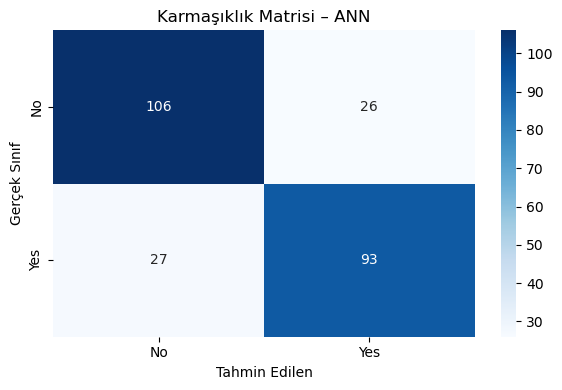

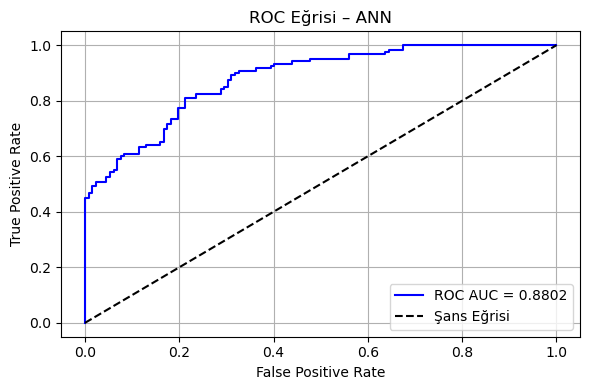

In [9]:
# Rapor
print("📋 Sınıflandırma Raporu (ANN):\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("Karmaşıklık Matrisi – ANN")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Sınıf")
plt.tight_layout()
plt.show()

# Sadece pozitif sınıfın (1) olasılığı alınır
y_score = y_pred_proba[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)

# Çizim
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}", color="blue")
plt.plot([0,1], [0,1], 'k--', label="Şans Eğrisi")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrisi – ANN")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()